In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#
import sys
sys.path.append('../code/utils/')
sys.path.append('../code')
import tools
from layers import wide_resnet
import datalib as dlib
import datatools as dtools
from time import time
#
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '/data2/cosmo4d/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100, 200, 300, 400]

In [3]:
suff = '-pad4'
num_cubes= 1000
cube_size = 32
pad = 4
cube_sizeft = cube_size + 2*pad
max_offset = ncp - cube_size
ftname = ['cic']
nchannels = len(ftname)

In [24]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    massall = np.log10(tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/Mass/')[1:].reshape(-1))
    hposd = hposall[:num].copy()
    massd = massall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp, massd)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['pnn']
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, num_cubes, max_offset, cube_size, cube_sizeft)
    cube_features = cube_features + features
    cube_target = cube_target + target

#
cube_target = np.stack(cube_target,axis=0).reshape((-1,cube_size,cube_size,cube_size,1))
print(cube_target.sum(), cube_target.size, targetmesh.sum())
print(len(cube_features))
print(cube_features[0].shape)
cube_features = np.stack(cube_features,axis=0).reshape((-1,cube_sizeft,cube_sizeft,cube_sizeft,nchannels))
trainingsize = cube_features.shape[0]
print('Training size is = ', trainingsize)


All the mesh have been generated for seed = 100
All the mesh have been generated for seed = 200
All the mesh have been generated for seed = 300
All the mesh have been generated for seed = 400
12502169.46855986 131072000 199852.83627349092
4000
(40, 40, 40, 1)
Training size is =  4000


Text(0.5, 1.0, 'Target')

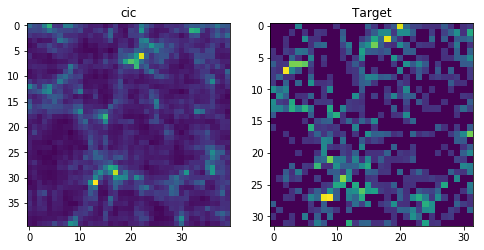

In [25]:
fig, ax = plt.subplots(1, nchannels+1, figsize = (nchannels*4+4, 5))
n = 10
for i in range(nchannels):
    ax[i].imshow(cube_features[n][:,:,:,i].sum(axis=0))
    ax[i].set_title(ftname[i])
ax[-1].imshow(cube_target[n][:,:,:,0].sum(axis=0))
ax[-1].set_title('Target')

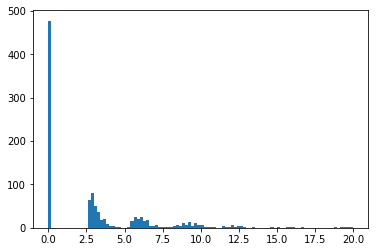

In [26]:
hist(cube_target[n][:,:,:,0].sum(axis=0).flatten(),100);

In [7]:
import tensorflow_probability
tfd = tensorflow_probability.distributions

In [8]:
# Define the network
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
y = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 1], name='labels')
m = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size], name='mask')

lr = tf.placeholder(tf.float32, name='learningrate')

net = slim.conv3d(x, 16, 5, activation_fn=tf.nn.leaky_relu, padding='valid')
net = slim.conv3d(net, 32, 5, activation_fn=None, padding='valid')
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = wide_resnet(net, 32, activation_fn=tf.nn.leaky_relu)
net = slim.conv3d(net, 64, 1, activation_fn=tf.nn.tanh)

n_mixture = 8

# Create mixture components from network output
out_mu = slim.conv3d(net, n_mixture, 1, activation_fn=None)
out_mu = tf.expand_dims(out_mu,-1)
out_sigma = slim.conv3d(net, n_mixture, 1, activation_fn=tf.nn.softplus) + 1e-2
out_sigma = tf.expand_dims(out_sigma,-1)
out_p = slim.conv3d(net, n_mixture, 1, activation_fn=None)
out_p = tf.nn.softmax(out_p)

# Predicted mask
out_mask = slim.conv3d(net, 1, 1, activation_fn=None)
pred_mask = tf.nn.sigmoid(out_mask)

gmm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=out_p),
                      components_distribution=tfd.MultivariateNormalDiag(loc=out_mu, scale_diag=out_sigma))

loss = - tf.reduce_mean(gmm.log_prob(y) * m) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=out_mask,
                                                                                                      labels=tf.expand_dims(m,-1)))

optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='optimizer')

opt_op = optimizer.minimize(loss, name='minimize')

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = []

niter= 100000
nprint = 100
batch_size=32

In [19]:
#
start = time()
curr = time()
lr0, nlr = 0.001, int(2000)
lacc = 0 
for it in range(niter):
    inds = np.random.choice(int(trainingsize), batch_size, replace=False)
    _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], y:cube_target[inds], m:1.*(squeeze(cube_target[inds])>0) })
    lacc += l
    if it % nlr == nlr-1:
        lr0 /= 10
        print('reduce learning rate by half. New learning rate = %0.2e'%lr0)        
    if it % nprint == 0:
        print('Iteration %d of %d'%(it, niter), '\nLoss = ', lacc/nprint)
        end = time()
        print('Time taken for last batch = %0.3f, Total time elapsed = %0.3f'%(end-curr, end - start))
        lacc=0
        curr = end
    losses.append(l)

Iteration 0 of 100000 
Loss =  0.0006046649441123009
Time taken for last batch = 0.681, Total time elapsed = 0.681
Iteration 100 of 100000 
Loss =  0.05798982247710228
Time taken for last batch = 68.078, Total time elapsed = 68.760
Iteration 200 of 100000 
Loss =  0.05519702147692442
Time taken for last batch = 68.901, Total time elapsed = 137.661
Iteration 300 of 100000 
Loss =  0.05354920633137226
Time taken for last batch = 68.549, Total time elapsed = 206.210
Iteration 400 of 100000 
Loss =  0.05024115886539221
Time taken for last batch = 68.432, Total time elapsed = 274.641
Iteration 500 of 100000 
Loss =  0.04915091253817081
Time taken for last batch = 68.598, Total time elapsed = 343.239
Iteration 600 of 100000 
Loss =  0.044977979250252244
Time taken for last batch = 68.463, Total time elapsed = 411.702
Iteration 700 of 100000 
Loss =  0.04240097552537918
Time taken for last batch = 68.403, Total time elapsed = 480.106
Iteration 800 of 100000 
Loss =  0.04064094115048647
Time t

Iteration 6700 of 100000 
Loss =  0.010568902976810932
Time taken for last batch = 68.396, Total time elapsed = 4590.294
Iteration 6800 of 100000 
Loss =  0.010970645789057017
Time taken for last batch = 68.684, Total time elapsed = 4658.978
Iteration 6900 of 100000 
Loss =  0.011265424154698849
Time taken for last batch = 68.603, Total time elapsed = 4727.581
Iteration 7000 of 100000 
Loss =  0.011237465310841799
Time taken for last batch = 68.351, Total time elapsed = 4795.932
Iteration 7100 of 100000 
Loss =  0.01078639568760991
Time taken for last batch = 68.619, Total time elapsed = 4864.550
Iteration 7200 of 100000 
Loss =  0.011204948127269744
Time taken for last batch = 68.511, Total time elapsed = 4933.061
Iteration 7300 of 100000 
Loss =  0.0106938555277884
Time taken for last batch = 68.417, Total time elapsed = 5001.478
Iteration 7400 of 100000 
Loss =  0.010539981015026569
Time taken for last batch = 68.397, Total time elapsed = 5069.875
Iteration 7500 of 100000 
Loss =  0

Iteration 13400 of 100000 
Loss =  0.011436643693596125
Time taken for last batch = 68.542, Total time elapsed = 9178.580
Iteration 13500 of 100000 
Loss =  0.010578156262636185
Time taken for last batch = 68.463, Total time elapsed = 9247.042
Iteration 13600 of 100000 
Loss =  0.01084377022460103
Time taken for last batch = 68.451, Total time elapsed = 9315.494
Iteration 13700 of 100000 
Loss =  0.011551821660250426
Time taken for last batch = 68.507, Total time elapsed = 9384.001
Iteration 13800 of 100000 
Loss =  0.01117248898372054
Time taken for last batch = 68.523, Total time elapsed = 9452.524
Iteration 13900 of 100000 
Loss =  0.010225962921977043
Time taken for last batch = 68.459, Total time elapsed = 9520.982
reduce learning rate by half. New learning rate = 1.00e-10
Iteration 14000 of 100000 
Loss =  0.010511777121573687
Time taken for last batch = 68.670, Total time elapsed = 9589.652
Iteration 14100 of 100000 
Loss =  0.011055035907775164
Time taken for last batch = 68.48

reduce learning rate by half. New learning rate = 1.00e-13
Iteration 20000 of 100000 
Loss =  0.010203445479273796
Time taken for last batch = 68.612, Total time elapsed = 13697.228
Iteration 20100 of 100000 
Loss =  0.011574794873595237
Time taken for last batch = 68.515, Total time elapsed = 13765.743
Iteration 20200 of 100000 
Loss =  0.01142667168751359
Time taken for last batch = 68.562, Total time elapsed = 13834.305
Iteration 20300 of 100000 
Loss =  0.010914103146642446
Time taken for last batch = 68.328, Total time elapsed = 13902.633
Iteration 20400 of 100000 
Loss =  0.010866045877337456
Time taken for last batch = 68.265, Total time elapsed = 13970.898
Iteration 20500 of 100000 
Loss =  0.010548583641648292
Time taken for last batch = 68.467, Total time elapsed = 14039.365
Iteration 20600 of 100000 
Loss =  0.011278149466961622
Time taken for last batch = 68.569, Total time elapsed = 14107.935
Iteration 20700 of 100000 
Loss =  0.010278297513723373
Time taken for last batch

Iteration 26500 of 100000 
Loss =  0.01127756454050541
Time taken for last batch = 68.651, Total time elapsed = 18150.775
Iteration 26600 of 100000 
Loss =  0.010757118556648492
Time taken for last batch = 68.428, Total time elapsed = 18219.204
Iteration 26700 of 100000 
Loss =  0.010920614413917064
Time taken for last batch = 68.551, Total time elapsed = 18287.755
Iteration 26800 of 100000 
Loss =  0.011362584922462702
Time taken for last batch = 68.409, Total time elapsed = 18356.164
Iteration 26900 of 100000 
Loss =  0.011093125622719526
Time taken for last batch = 68.460, Total time elapsed = 18424.623
Iteration 27000 of 100000 
Loss =  0.010528339371085167
Time taken for last batch = 68.642, Total time elapsed = 18493.265
Iteration 27100 of 100000 
Loss =  0.011336871329694987
Time taken for last batch = 68.405, Total time elapsed = 18561.670
Iteration 27200 of 100000 
Loss =  0.0117156651802361
Time taken for last batch = 68.547, Total time elapsed = 18630.217
Iteration 27300 of 

Iteration 33100 of 100000 
Loss =  0.010814336556941272
Time taken for last batch = 68.423, Total time elapsed = 22671.642
Iteration 33200 of 100000 
Loss =  0.010754439998418092
Time taken for last batch = 68.399, Total time elapsed = 22740.042
Iteration 33300 of 100000 
Loss =  0.011255943179130555
Time taken for last batch = 68.299, Total time elapsed = 22808.341
Iteration 33400 of 100000 
Loss =  0.010993827246129512
Time taken for last batch = 68.557, Total time elapsed = 22876.899
Iteration 33500 of 100000 
Loss =  0.010870589632540941
Time taken for last batch = 68.623, Total time elapsed = 22945.521
Iteration 33600 of 100000 
Loss =  0.01085029486566782
Time taken for last batch = 68.413, Total time elapsed = 23013.935
Iteration 33700 of 100000 
Loss =  0.011139796245843173
Time taken for last batch = 68.351, Total time elapsed = 23082.285
Iteration 33800 of 100000 
Loss =  0.010678001213818789
Time taken for last batch = 68.491, Total time elapsed = 23150.776
Iteration 33900 o

Iteration 39700 of 100000 
Loss =  0.010915223434567451
Time taken for last batch = 68.265, Total time elapsed = 27191.081
Iteration 39800 of 100000 
Loss =  0.01090279472991824
Time taken for last batch = 68.527, Total time elapsed = 27259.609
Iteration 39900 of 100000 
Loss =  0.011370638273656369
Time taken for last batch = 68.354, Total time elapsed = 27327.962
reduce learning rate by half. New learning rate = 1.00e-23
Iteration 40000 of 100000 
Loss =  0.010391924679279328
Time taken for last batch = 68.393, Total time elapsed = 27396.355
Iteration 40100 of 100000 
Loss =  0.011078169737011194
Time taken for last batch = 68.634, Total time elapsed = 27464.988
Iteration 40200 of 100000 
Loss =  0.011766029465943574
Time taken for last batch = 68.451, Total time elapsed = 27533.440
Iteration 40300 of 100000 
Loss =  0.010909322183579206
Time taken for last batch = 68.652, Total time elapsed = 27602.092
Iteration 40400 of 100000 
Loss =  0.010787205025553703
Time taken for last batch

Iteration 46200 of 100000 
Loss =  0.010576817095279694
Time taken for last batch = 68.406, Total time elapsed = 31642.051
Iteration 46300 of 100000 
Loss =  0.011053702719509602
Time taken for last batch = 68.564, Total time elapsed = 31710.615
Iteration 46400 of 100000 
Loss =  0.010938825253397226
Time taken for last batch = 68.543, Total time elapsed = 31779.159
Iteration 46500 of 100000 
Loss =  0.011044024880975485
Time taken for last batch = 68.673, Total time elapsed = 31847.832
Iteration 46600 of 100000 
Loss =  0.010583182666450738
Time taken for last batch = 68.463, Total time elapsed = 31916.295
Iteration 46700 of 100000 
Loss =  0.010765986070036888
Time taken for last batch = 68.345, Total time elapsed = 31984.639
Iteration 46800 of 100000 
Loss =  0.010894334688782693
Time taken for last batch = 68.691, Total time elapsed = 32053.330
Iteration 46900 of 100000 
Loss =  0.011325852274894714
Time taken for last batch = 68.378, Total time elapsed = 32121.708
Iteration 47000 

Iteration 52800 of 100000 
Loss =  0.01117776844650507
Time taken for last batch = 68.485, Total time elapsed = 36163.644
Iteration 52900 of 100000 
Loss =  0.011129972860217094
Time taken for last batch = 68.622, Total time elapsed = 36232.266
Iteration 53000 of 100000 
Loss =  0.011278259251266718
Time taken for last batch = 68.449, Total time elapsed = 36300.715
Iteration 53100 of 100000 
Loss =  0.010766713954508305
Time taken for last batch = 68.459, Total time elapsed = 36369.174
Iteration 53200 of 100000 
Loss =  0.010914212800562382
Time taken for last batch = 68.828, Total time elapsed = 36438.001
Iteration 53300 of 100000 
Loss =  0.010852700658142566
Time taken for last batch = 68.408, Total time elapsed = 36506.409
Iteration 53400 of 100000 
Loss =  0.010919994581490755
Time taken for last batch = 68.389, Total time elapsed = 36574.798
Iteration 53500 of 100000 
Loss =  0.010691631007939578
Time taken for last batch = 68.620, Total time elapsed = 36643.418
Iteration 53600 o

KeyboardInterrupt: 

In [ ]:
#
start = time()
curr = time()
lr0, nlr = 0.00001, int(2000)
lacc = 0 
for it in range(niter):
    inds = np.random.choice(int(trainingsize), batch_size, replace=False)
    _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, x:cube_features[inds], y:cube_target[inds], m:1.*(squeeze(cube_target[inds])>0) })
    lacc += l
    if it % nlr == nlr-1:
        lr0 /= 10
        print('reduce learning rate by half. New learning rate = %0.2e'%lr0)        
    if it % nprint == 0:
        print('Iteration %d of %d'%(it, niter), '\nLoss = ', lacc/nprint)
        end = time()
        print('Time taken for last batch = %0.3f, Total time elapsed = %0.3f'%(end-curr, end - start))
        lacc=0
        curr = end
    losses.append(l)

Iteration 0 of 100000 
Loss =  0.000138726644217968
Time taken for last batch = 0.679, Total time elapsed = 0.679


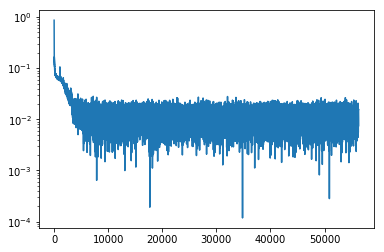

In [20]:
plot(losses)
yscale('log')


Text(0.5, 1.0, 'features')

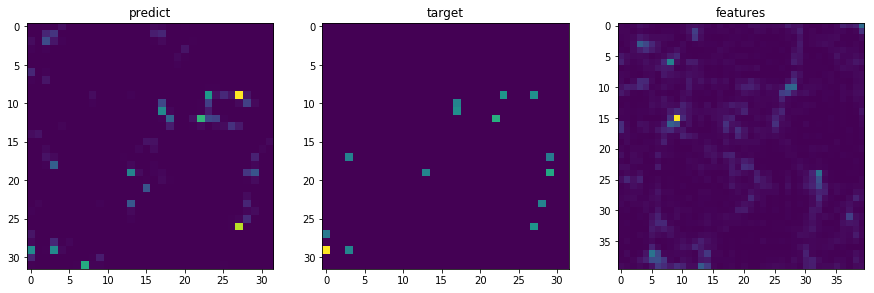

In [21]:
ind = 0
input = cube_features[ind]
recp, recm = sess.run([gmm.sample(), pred_mask], feed_dict={x:input.reshape(1, *input.shape)})

fig, ax = plt.subplots(1, 3, figsize=(15,7))
ax[0].imshow(recp[ind,0,:,:,0] * recm[ind,0,:,:,0]);
ax[0].set_title('predict')
ax[1].imshow(cube_target[ind,0,:,:,0]);
ax[1].set_title('target')
ax[2].imshow(cube_features[ind,0,:,:,0]);
ax[2].set_title('features')

In [22]:
input = x
prediction = gmm.sample()
#############################
meshes = {}
cube_features, cube_target = [], []
for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]
    massall = np.log10(tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/Mass/')[1:].reshape(-1))
    hposd = hposall[:num].copy()
    massd = massall[:num].copy()
    hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['target'] = hmesh['pnn'].copy()
    
    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = hmesh['target']

    ncube = int(ncp/cube_size)
    inp = dtools.splitvoxels(ftlistpad, cube_size=cube_sizeft, shift=cube_size, ncube=ncube)
    recp,recm = sess.run([prediction, pred_mask], feed_dict={input:inp})
    mesh['predict'] = dtools.uncubify(recp[:,:,:,:,0], [nc,nc,nc])
    mesh['mask'] = dtools.uncubify(recm[:,:,:,:,0], [nc,nc,nc])
    
    meshes[seed] = [mesh, hmesh]

All the mesh have been generated for seed = 100
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 200
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 300
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]
All the mesh have been generated for seed = 400
(32, 32, 32) [128 128 128]
(32, 32, 32) [128 128 128]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: R

Text(0.5, 1.0, 'Predict')

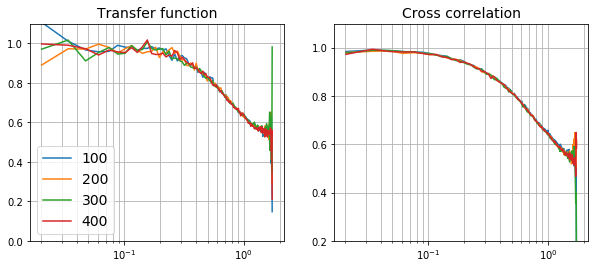

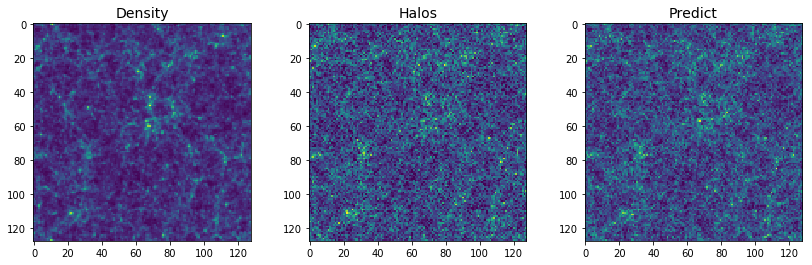

In [23]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'] * (meshes[seed][0]['mask']), meshes[seed][1]['target'], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)
    
    ##
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)
    
ax[0].legend(fontsize=14)
ax[0].grid(which='both')
ax[1].grid(which='both')
ax[0].set_title('Transfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
#plt.savefig('./figs/n%02d/2ptpredict%s.png'%(numd*1e4, suff))
ax[0].set_ylim(0.,1.1)
ax[1].set_ylim(0.2,1.1)

fig, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(meshes[seed][0]['cic'].sum(axis=0))
ax[0].set_title('Density', fontsize=14)
ax[1].imshow(meshes[seed][1]['target'].sum(axis=0),vmin=0,vmax=50)
ax[1].set_title('Halos', fontsize=14)
ax[2].imshow((meshes[seed][0]['predict'] * (meshes[seed][0]['mask'])).sum(axis=0),vmin=0,vmax=50)
ax[2].set_title('Predict', fontsize=14)
#plt.savefig('./figs/n%02d/impredict%s.png'%(numd*1e4, suff))



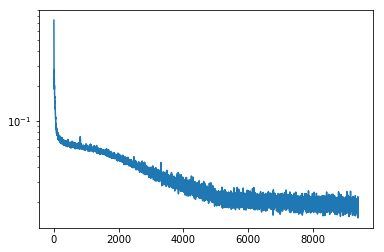

In [32]:
# Some previous results
plot(losses)
yscale('log')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Predict')

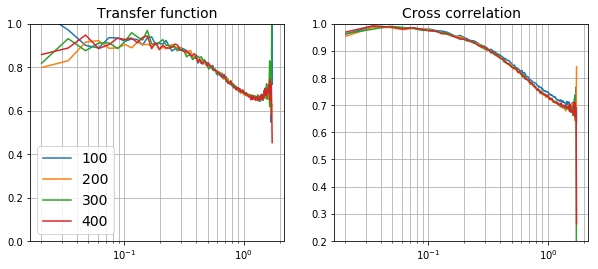

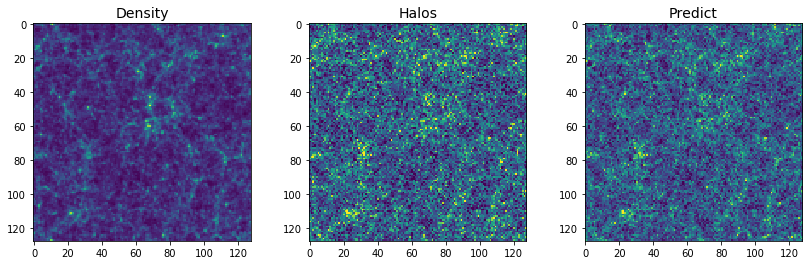

In [30]:
##############################
##Power spectrum
shape = [nc,nc,nc]
kk = tools.fftk(shape, bs)
kmesh = sum(i**2 for i in kk)**0.5


fig, ax = plt.subplots(1, 2, figsize = (10, 4))
for seed in seeds:
    predict, hpmeshd = meshes[seed][0]['predict'], meshes[seed][1]['target'], 
    k, pkpred = tools.power(predict/predict.mean(), boxsize=bs, k=kmesh)
    k, pkhd = tools.power(hpmeshd/hpmeshd.mean(), boxsize=bs, k=kmesh)
    k, pkhx = tools.power(hpmeshd/hpmeshd.mean(), predict/predict.mean(), boxsize=bs, k=kmesh)
    #k, pkpredall = tools.power(predictall/predictall.mean(), boxsize=bs, k=kmesh)
    #k, pkhallx = tools.power(hpmeshd/hpmeshd.mean(), predictall/predictall.mean(), boxsize=bs, k=kmesh)
    
    ##
    ax[0].semilogx(k, pkpred/pkhd, label=seed)
    ax[1].semilogx(k, pkhx/(pkpred*pkhd)**0.5)
    # plt.plot(k, pkpredall/pkhd)
    
ax[0].legend(fontsize=14)
ax[0].grid(which='both')
ax[1].grid(which='both')
ax[0].set_title('Transfer function', fontsize=14)
ax[1].set_title('Cross correlation', fontsize=14)
#plt.savefig('./figs/n%02d/2ptpredict%s.png'%(numd*1e4, suff))
ax[0].set_ylim(0.,1)
ax[1].set_ylim(0.2,1)

fig, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(meshes[seed][0]['cic'].sum(axis=0))
ax[0].set_title('Density', fontsize=14)
ax[1].imshow(meshes[seed][1]['target'].sum(axis=0),vmin=0,vmax=12)
ax[1].set_title('Halos', fontsize=14)
ax[2].imshow(meshes[seed][0]['predict'].sum(axis=0),vmin=0,vmax=12)
ax[2].set_title('Predict', fontsize=14)
#plt.savefig('./figs/n%02d/impredict%s.png'%(numd*1e4, suff))

